The following is a simple demonstration of the MuJoCo physics engine, designed to demonstrate the multibody simulation capabilities of the package. 

We will use a double pendulum setup to demonstrate the gravity, damping, and control features of the package. 

First, we will import all the packages needed. We will import the physics engine, its viewer, as well as some data visualization packages. 

In [73]:
import mujoco
import mujoco.viewer
import numpy as np
import matplotlib.pyplot as plt
import time

Next, we will define our physical model, via an XML string. Note the gravity, hinge definitions, and actuator definitions. 

In [74]:
model_xml = """
<mujoco>
<option gravity="0 0 -9.81" timestep="0.0005"/>
<worldbody>
<body name="link1" pos="0 0 0">
<joint name="hinge1" type="hinge" axis="0 1 0" damping="0.01"/>
<geom type="capsule" fromto="0 0 0 0 0 -0.5" size="0.03" rgba="0.2 0.5 0.9 1"/>
<body name="link2" pos="0 0 -0.5">
<joint name="hinge2" type="hinge" axis="0 1 0" damping="0.01"/>
<geom type="capsule" fromto="0 0 0 0 0 -0.5" size="0.05" rgba="0.9 0.3 0.3 1"/>
</body>
</body>
</worldbody>
<actuator>
<motor joint="hinge1" ctrllimited="true" ctrlrange="-1 1"/>
<motor joint="hinge2" ctrllimited="true" ctrlrange="-1 1"/>
</actuator>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(model_xml)
data = mujoco.MjData(model)

Lets run the pendulum under gravity. As a double pendulum, we can observe some natural chaos. While this seems pretty simple, the C engine is computing the accelerations, constraint forces, and gravity in the background. 

In [75]:
data.qpos[:] = [np.pi / 2, np.pi / 2] # [upper, lower] link angle in radians


We will also log states (collect data at every timestep)

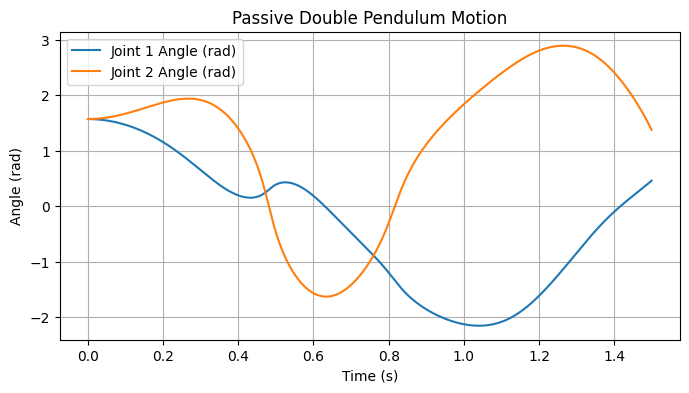

In [76]:
q_log = []
t_log = []


for i in range(3000): # 3 seconds at 1 kHz
    mujoco.mj_step(model, data)
    q_log.append(data.qpos.copy())
    t_log.append(i * model.opt.timestep)


q_log = np.array(q_log)
t_log = np.array(t_log)


plt.figure(figsize=(8,4))
plt.plot(t_log, q_log[:,0], label='Joint 1 Angle (rad)')
plt.plot(t_log, q_log[:,1], label='Joint 2 Angle (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Passive Double Pendulum Motion')
plt.legend()
plt.grid()
plt.show()

This is all pretty simple so far. Let's now adjust some parameters, to see the impact on the motion of the pendulum. We can add some damping to simulate energy loss, and also show off MuJoCo's actuation with some applied torques. 

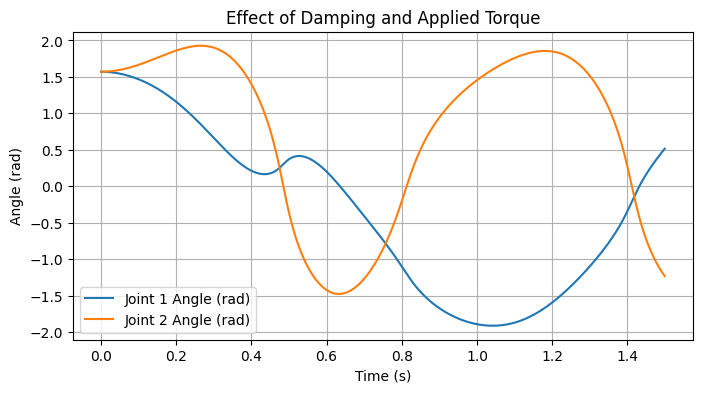

In [77]:
model.dof_damping[:] = 0.1 # increase damping
data.qpos[:] = [np.pi/2, np.pi/2]
data.qvel[:] = 0


q_log2, t_log2 = [], []
for i in range(3000):
    torque = 0.5 if 1000 < i < 1500 else 0.0 # pulse torque
    data.ctrl[:] = [torque, 0]
    mujoco.mj_step(model, data)
    q_log2.append(data.qpos.copy())
    t_log2.append(i * model.opt.timestep)


q_log2, t_log2 = np.array(q_log2), np.array(t_log2)


plt.figure(figsize=(8,4))
plt.plot(t_log2, q_log2[:,0], label='Joint 1 Angle (rad)')
plt.plot(t_log2, q_log2[:,1], label='Joint 2 Angle (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Effect of Damping and Applied Torque')
plt.legend()
plt.grid()
plt.show()

We've all seen the iconic controls video of stabilizing a pendulum upright. Let's try that (feedback control loop) in our simulation!

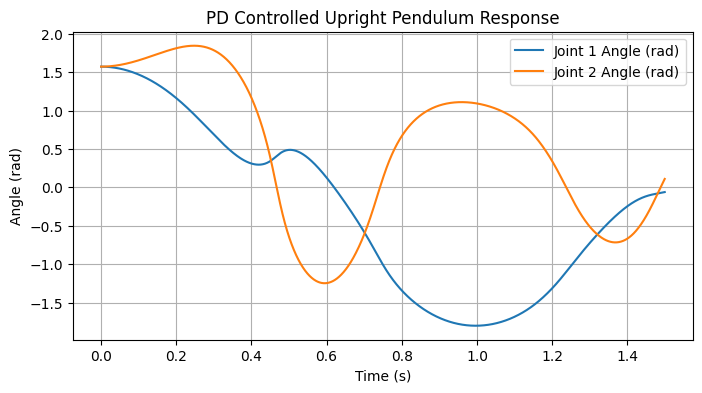

In [78]:
def pd_control(q, qdot, q_ref, kp, kd):
    return kp * (q_ref - q) - kd * qdot


q_ref = np.array([0.0, 0.0])


data.qpos[:] = [np.pi/2, np.pi/2]
data.qvel[:] = 0


q_log3, t_log3 = [], []


for i in range(3000):
    q = data.qpos.copy()
    qdot = data.qvel.copy()
    ctrl = pd_control(q, qdot, q_ref, kp=20, kd=2)
    data.ctrl[:] = ctrl
    mujoco.mj_step(model, data)
    q_log3.append(q)
    t_log3.append(i * model.opt.timestep)


q_log3, t_log3 = np.array(q_log3), np.array(t_log3)


plt.figure(figsize=(8,4))
plt.plot(t_log3, q_log3[:,0], label='Joint 1 Angle (rad)')
plt.plot(t_log3, q_log3[:,1], label='Joint 2 Angle (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('PD Controlled Upright Pendulum Response')
plt.legend()
plt.grid()
plt.show()

Okay, so we saw some numbers move around. Cool, but what about that real-time visualization in the slides? Let's launch the viewer!

In [79]:
with mujoco.viewer.launch_passive(model, data) as viewer:
    print("Phase 1: Passive motion")
    data.qpos[:] = [np.pi/2, np.pi/2]
    data.qvel[:] = 0
    model.dof_damping[:] = 0.01


    start = time.time()
    while viewer.is_running() and time.time() - start < 10.0:
        mujoco.mj_step(model, data)
        viewer.sync()
        #time.sleep(0.002)


    print("Phase 2: Increased damping with torque pulse")
    model.dof_damping[:] = 0.1
    data.qpos[:] = [np.pi/2, np.pi/2]
    data.qvel[:] = 0


    start = time.time()
    while viewer.is_running() and time.time() - start < 20.0:
        elapsed = time.time() - start
        data.ctrl[:] = [0.5, 0.0] if 1.0 < elapsed < 1.5 else [0.0, 0.0]
        mujoco.mj_step(model, data)
        viewer.sync()
        #time.sleep(0.002)


    print("Phase 3: PD control stabilization")
    q_ref = np.array([0.0, 0.0])
    data.qpos[:] = [np.pi/2, np.pi/2]
    data.qvel[:] = 0


    start = time.time()
    while viewer.is_running() and time.time() - start < 30.0:
        q = data.qpos.copy()
        qdot = data.qvel.copy()
        data.ctrl[:] = pd_control(q, qdot, q_ref, kp=20, kd=2)
        mujoco.mj_step(model, data)
        viewer.sync()
        #time.sleep(0.002)

Phase 1: Passive motion
Phase 2: Increased damping with torque pulse
Phase 3: PD control stabilization
